# Classic ML

## Packages

In [1]:
import os

import cv2
import numpy as np
import optuna as optuna
import matplotlib.pyplot as plt
import pandas as pd
from skimage.util import view_as_windows
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm

## Utils

In [2]:
def get_metrics(result, real):
    conf = confusion_matrix(result.flatten(), real.flatten())
    TN, FP, FN, TP = conf.ravel()

    accuracy = 1.0 * (TP + TN) / (TP + TN + FP + FN)
    sensitivity = 1.0 * TP / (TP + FN)
    specificity = 1.0 * TN / (TN + FP)

    return accuracy, sensitivity, specificity

In [3]:
sp_key = ('m00', 'm10', 'm01', 'm20', 'm11', 'm02', 'm30', 'm21', 'm12', 'm03')
nu_key = ('nu20','nu11','nu02','nu30','nu21','nu12','nu03')

ch_avg = [f'$\mu({x})$' for x in 'BGR']
ch_std = [f'$\sigma({x})$' for x in 'BGR']
hu_mom = [f'$I_{x+1}$' for x in range(7)]
sp_mom = ['$M_{'+x[1:]+'}$' for x in sp_key]
nu_mom = ['$\eta_{'+x[2:]+'}$' for x in nu_key]

features = ch_avg + ch_std + hu_mom + sp_mom + nu_mom

## Import data

In [4]:
path = '../data/HRF/'
files = sorted(os.listdir(path))
data = {
    'original': [],
    'labeled': [],
    'mask': []
}
for file in files:
    if file.endswith('h.jpg'):
        data['original'].append(cv2.imread(f'{path}{file}'))
    elif file.endswith('h.tif'):
        data['labeled'].append(cv2.imread(f'{path}{file}', 0))
    elif file.endswith('h_mask.tif'):
        data['mask'].append(cv2.imread(f'{path}{file}', 0))

In [5]:
for type_ in data:
    print(len(data[type_]))
    print(data[type_][0].shape, data[type_][0].max(), data[type_][0].min())

15
(2336, 3504, 3) 255 0
15
(2336, 3504) 255 0
15
(2336, 3504) 255 0


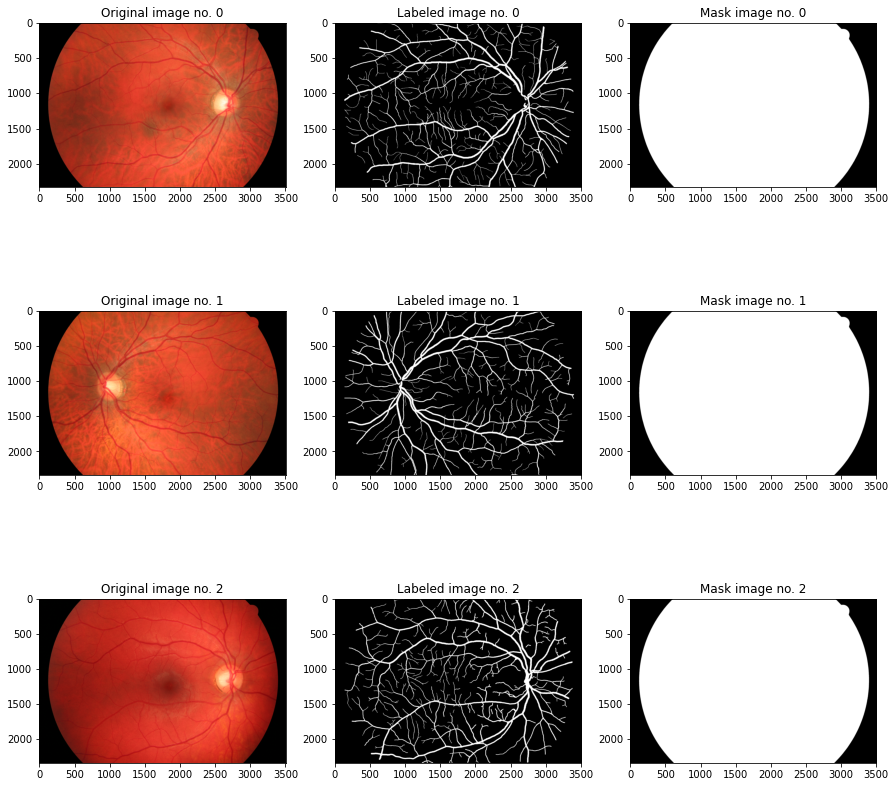

In [6]:
columns, rows = 3, 3
plt.figure(figsize=(5 * columns, 5 * rows))

for i in range(0, columns * rows):
    plt.subplot(rows, columns, i + 1)
    number = int(i / 3)
    if i % 3 == 0:
        img = data['original'][number]
        plt.title(f'Original image no. {number}')
        plt.imshow(img[:, :, ::-1])
    elif i % 3 == 1:
        img = data['labeled'][number]
        plt.title(f'Labeled image no. {number}')
        plt.imshow(img, cmap='gray')
    elif i % 3 == 2:
        img = data['mask'][number]
        plt.title(f'Mask image no. {number}')
        plt.imshow(img, cmap='gray')
plt.show()

In [7]:
def split_image(image, tile_size=4, step=None):
    gray = (len(image.shape) == 2) or (image.shape[2] == 1)
    if not step: step = tile_size
    return view_as_windows(image, (tile_size, tile_size), step=step).reshape(-1, tile_size, tile_size) if gray else view_as_windows(
        image, (tile_size, tile_size, 3), step=step).reshape(-1, tile_size, tile_size, 3)


def get_features(image):
    channels = image.reshape(-1, 3)
    mean, std = np.mean(channels, axis=0), np.std(channels, axis=0)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mom = cv2.moments(gray)
    hu = cv2.HuMoments(mom)[:, 0]
    sp, nu = [mom[k] for k in sp_key], [mom[k] for k in nu_key]
    return np.hstack([mean, std, hu, sp, nu])


def create_meta_data_row(row, step=None):
    image, label = row['original'], row['labeled']
    image = cv2.fastNlMeansDenoisingColored(image,None,5,5,7,21)
    X = np.array([get_features(x) for x in split_image(image, step=step)])
    y = split_image(image, step=step)[:, 3, 3] > 0
    return X, y


def meta_data(data):
    total = pd.DataFrame()
    for _, row in tqdm(list(data.iterrows())):
        X, y = create_meta_data_row(row, step=1)
        chunk = pd.DataFrame(data=X, columns=features)
        chunk['id'] = row.id
        chunk['label'] = y
        total = pd.concat([total, chunk])
    return total.reset_index(drop=True)

def resize_data(dataset):
    new_dataset = list()
    dim = (876, 584)
    for image in dataset:
        new_dataset.append(cv2.resize(image, dim, interpolation = cv2.INTER_AREA))
    return dataset

In [ ]:
data = pd.DataFrame(data)[['original', 'labeled']]
data['id'] = data.index
mdata = meta_data(data)
data_test = mdata.loc[:4]
data_train = mdata.loc[5:]

(8167833, 4, 4)


KeyboardInterrupt: 

In [ ]:
X_train, y_train = data_train[features], data_train['labels']
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
sampler = RandomUnderSampler(sampling_strategy=1, random_state=42)
X_train, y_train = sampler.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

def objective(trial):
    clf = RandomForestClassifier(n_estimators=500, max_features='sqrt', random_state=42, n_jobs=-1,
                                 max_depth=trial.suggest_int('max_depth', 2, 32, log=True),
                                 min_samples_leaf=trial.suggest_float('min_samples_leaf', 0.005, 100),
                                 min_samples_split=trial.suggest_float('min_samples_split', 0.005, 100))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='weighted')
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
print("Dictionary of parameter name and parameter values:",study.best_params)
print("The best observed value of the objective function:",study.best_value)
print("The best trial:",study.best_trial)

In [ ]:
def predict_vessels(data, id_, final_clf):
    predict_data = data.loc[data.id == id_]
    X, y = predict_data[features], predict_data['label']
    Y = final_clf.predict_proba(X)[:,1] > 0.7
    return Y